# 4 データ前処理

## 4.1 欠損データへの対処

In [52]:
from IPython.core.display import display
import pandas as pd
from io import StringIO
csv_data = '''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,'''
df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [53]:
# 各特徴量の欠測値をカウント
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

In [54]:
df.values

array([[  1.,   2.,   3.,   4.],
       [  5.,   6.,  nan,   8.],
       [ 10.,  11.,  12.,  nan]])

### 4.1.1 欠測値を持つサンプル/特徴量を取り除く

In [55]:
# 欠測値を含む行を削除
df.dropna()

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [56]:
# 欠測値を含む列を削除
df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


In [57]:
# すべての列がNaNである行だけを削除
df.dropna(how='all')
# 非NaN値が4つ未満の行を削除
df.dropna(thresh=4)
# 特定の列にNaNが含まれている行だけを削除
df.dropna(subset=['C'])

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


### 4.1.2 欠測値を補完する

In [58]:
from sklearn.preprocessing import Imputer
# 欠測値補完のインスタンスを生成(平均値補完)
# median: 中央値、most_frequent: 最頻値
imr = Imputer(missing_values='NaN', strategy='mean', axis=0)
# データを適合
imr = imr.fit(df)
# 補完を実行
imputed_data = imr.transform(df.values)
imputed_data

array([[  1. ,   2. ,   3. ,   4. ],
       [  5. ,   6. ,   7.5,   8. ],
       [ 10. ,  11. ,  12. ,   6. ]])

## 4.2 カテゴリデータの処理

In [59]:
import pandas as pd
# サンプルデータを生成
df = pd.DataFrame([
    ['green', 'M', 10.1, 'class1'],
    ['red', 'L', 13.5, 'class2'],
    ['blue', 'XL', 15.3, 'class1'],
])
# 列名を設定
df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class1
1,red,L,13.5,class2
2,blue,XL,15.3,class1


### 4.2.1 順序特徴量のマッピング

In [60]:
# Tシャツのサイズと整数を対応させるディクショナリを生成
size_mapping = {'XL': 3, 'L': 2, 'M': 1}
# Tシャツのサイズを整数に変換
df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


In [61]:
# Tシャツのサイズを文字列に戻す辞書
inv_size_mapping = {v: k for k, v in size_mapping.items()}
inv_size_mapping

{1: 'M', 2: 'L', 3: 'XL'}

### 4.2.2 クラスラベルのエンコーディング

In [62]:
import numpy as np
# クラスラベルと整数を対応させる辞書
class_mapping = {label: i for i, label in enumerate(np.unique(df['classlabel']))}
class_mapping

{'class1': 0, 'class2': 1}

In [63]:
# クラスラベルを整数に変換
df['classlabel'] = df['classlabel'].map(class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,0
1,red,2,13.5,1
2,blue,3,15.3,0


In [64]:
inv_class_mapping = {v: k for k, v in class_mapping.items()}
# 整数からクラスラベルに変換
df['classlabel'] = df['classlabel'].map(inv_class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


In [65]:
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values)
y

array([0, 1, 0])

In [66]:
class_le.inverse_transform(y)

array(['class1', 'class2', 'class1'], dtype=object)

### 4.2.3 名義特徴量での one-hot エンコーディング

In [67]:
# Tシャツの色、サイズ、価格を抽出
X = df[['color', 'size', 'price']].values
color_le = LabelEncoder()
X[:, 0] = color_le.fit_transform(X[:, 0])
X

array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

In [68]:
from sklearn.preprocessing import OneHotEncoder
# one-hot エンコーダの生成
ohe = OneHotEncoder(categorical_features=[0])
# one-hot エンコーディングを実行
ohe.fit_transform(X).toarray()

array([[  0. ,   1. ,   0. ,   1. ,  10.1],
       [  0. ,   0. ,   1. ,   2. ,  13.5],
       [  1. ,   0. ,   0. ,   3. ,  15.3]])

In [69]:
# one-hot エンコーディングを実行
pd.get_dummies(df[['price', 'color', 'size']])

,price,size,color_blue,color_green,color_red
0,10.1,1,0,1,0
1,13.5,2,0,0,1
2,15.3,3,1,0,0


## 4.3 データセットをトレーニングデータセットとテストデータセットに分割する

In [70]:
# http://archive.ics.uci.edu/ml/datasets/Wine
df_wine = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
display(df_wine.head())
# 列名を設定
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']
display(df_wine.head())
print('Class labels', np.unique(df_wine['Class label']))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


Class labels [1 2 3]


In [71]:
from sklearn.cross_validation import train_test_split
# 特徴量とクラスラベルを別々に抽出
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
# 全体の30%をテストデータにする
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## 4.4 特徴量の尺度を揃える

In [72]:
from sklearn.preprocessing import MinMaxScaler
# min-max スケーリングのインスタンスを生成
mms = MinMaxScaler()
# トレーニングデータをスケーリング
X_train_norm = mms.fit_transform(X_train)
# テストデータをスケーリング
X_test_norm = mms.transform(X_test)
X_train, X_train_norm

(array([[  1.37100000e+01,   1.86000000e+00,   2.36000000e+00, ...,
           1.11000000e+00,   4.00000000e+00,   1.03500000e+03],
        [  1.22200000e+01,   1.29000000e+00,   1.94000000e+00, ...,
           8.60000000e-01,   3.02000000e+00,   3.12000000e+02],
        [  1.32700000e+01,   4.28000000e+00,   2.26000000e+00, ...,
           5.90000000e-01,   1.56000000e+00,   8.35000000e+02],
        ..., 
        [  1.24200000e+01,   1.61000000e+00,   2.19000000e+00, ...,
           1.06000000e+00,   2.96000000e+00,   3.45000000e+02],
        [  1.39000000e+01,   1.68000000e+00,   2.12000000e+00, ...,
           9.10000000e-01,   3.33000000e+00,   9.85000000e+02],
        [  1.41600000e+01,   2.51000000e+00,   2.48000000e+00, ...,
           6.20000000e-01,   1.71000000e+00,   6.60000000e+02]]),
 array([[ 0.72043011,  0.20378151,  0.53763441, ...,  0.48717949,
          1.        ,  0.5854251 ],
        [ 0.31989247,  0.08403361,  0.31182796, ...,  0.27350427,
          0.64102564,  0

In [73]:
from sklearn.preprocessing import StandardScaler
# 標準化のインスタンスを生成
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)
X_train_std

array([[ 0.91083058, -0.46259897, -0.01142613, ...,  0.65706596,
         1.94354495,  0.93700997],
       [-0.95609928, -0.96608672, -1.53725357, ..., -0.40859506,
         0.58118003, -1.41336684],
       [ 0.35952243,  1.67501572, -0.37471838, ..., -1.55950896,
        -1.44846566,  0.28683658],
       ..., 
       [-0.70550467, -0.68342693, -0.62902295, ...,  0.44393375,
         0.49776993, -1.30608823],
       [ 1.14889546, -0.6215951 , -0.88332752, ..., -0.19546286,
         1.0121322 ,  0.77446662],
       [ 1.47466845,  0.11155374,  0.42452457, ..., -1.43162964,
        -1.23994042, -0.28206514]])

## 4.5 有益な特徴量の選択

### 4.5.1 L1 正則化による疎な解

In [74]:
from sklearn.linear_model import LogisticRegression
# L1正則化ロジスティック回帰のインスタンスを生成
LogisticRegression(penalty='l1')
# L1正則化ロジスティック回帰のインスタンスを生成(逆正則化パラメータ C=0.1)
lr = LogisticRegression(penalty='l1', C=0.1)
lr.fit(X_train_std, y_train)
print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))

Training accuracy: 0.983870967742
Test accuracy: 0.981481481481


In [75]:
# 切片の表示
lr.intercept_

array([-0.38381474, -0.15816015, -0.70046295])

In [76]:
# 重み係数の表示
lr.coef_

array([[ 0.28000469,  0.        ,  0.        , -0.02759822,  0.        ,
         0.        ,  0.71003507,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.23687776],
       [-0.64367761, -0.06889316, -0.05716261,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.92722712,
         0.05974922,  0.        , -0.37101806],
       [ 0.        ,  0.06156184,  0.        ,  0.        ,  0.        ,
         0.        , -0.63556048,  0.        ,  0.        ,  0.49776678,
        -0.35830846, -0.5717413 ,  0.        ]])

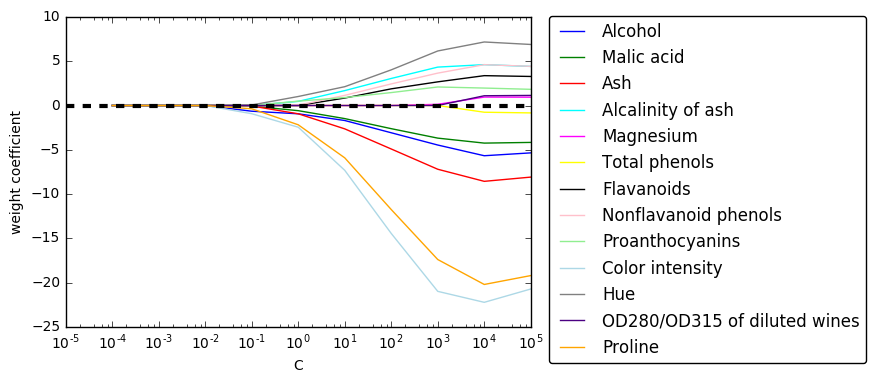

In [77]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.subplot(111)
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black',
          'pink', 'lightgreen', 'lightblue', 'gray', 'indigo', 'orange']
# 空のリストを生成(重み係数、逆正則化パラメータ
weights, params = [], []
# 逆正則化パラメータの値ごとに処理
for c in np.arange(-4, 6):
    # print(c) # -4~5 
    lr = LogisticRegression(penalty='l1', C=10 ** c, random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10 ** c)
    
# 重み係数をNumPy配列に変換
weights = np.array(weights)
# 各重み係数をプロット
# print(weights.shape[1]) # -> 13
for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column], label=df_wine.columns[column + 1], color=color)
    
# y=0 に黒い破線を引く
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10 ** (-5), 10 ** 5])
# 軸のラベルの設定
plt.ylabel('weight coefficient')
plt.xlabel('C')
# 横軸を対数スケールに設定
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', bbox_to_anchor=(1.38, 1.03), ncol=1, fancybox=True)
plt.show()

### 4.5.2 逐次特徴選択アルゴリズム

In [78]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

class SBS():
    """
    逐次後退選択(sequencial backward selection)を実行するクラス
    """
    
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring            # 特徴量を評価する指標
        self.estimator = clone(estimator) # 推定器
        self.k_features = k_features      # 選択する特徴量の個数
        self.test_size = test_size        # テストデータの悪愛
        self.random_state = random_state  # 乱数種を固定する random_state
        
    def fit(self, X, y):
        # トレーニングデータとテストデータに分割
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size,
                                                            random_state=self.random_state)
        # 全ての特徴量の個数、列インデックス
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        # 全ての特徴量を用いてスコアを算出
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        # スコアを格納
        self.scores_ = [score]
        # 指定した特徴量の個数になるまで処理を反復
        while dim > self.k_features:
            # 空のリストの生成(スコア、列インデックス)
            scores = []
            subsets = []
            # 特徴量の部分集合を表す列インデックスの組み合わせ毎に処理を反復
            for p in combinations(self.indices_, r=dim - 1):
                # スコアを算出して格納
                score = self._calc_score(X_train, y_tain, X_test, y_test, p)
                scores.append(score)
                # 特徴量の部分集合を表す列インデックスのリストを格納
                subsets.append(p)
                
            # 最良のスコアのインデックスを抽出
            best = np.argmax(scores)
            # 最良のスコアとなる列インデックスを抽出して格納
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            # 特徴量の個数を1つだけ減らして次のステップへ
            dim -= 1
            
            # スコアを格納
            self.scores_.append(scores[best])
            
        # 最後に格納したスコア
        self.k_score_ = self.scores_[-1]
        
        return self
    
    def transform(self, X):
        # 抽出した特徴量を返す
        return X[:, self.indices_]
    
    def _calc_score(self, X_train, y_tain, X_test, y_test, indices):
        # 指定された列番号 indices の特徴量を抽出してモデルに適合
        self.estimator.fit(X_train[:, indices], y_train)
        # テストデータを用いてクラスラベルを予測
        y_pred = self.estimator.predict(X_test[:, indices])
        # 真のクラスラベルと予測値を用いてスコアを算出
        score = self.scoring(y_test, y_pred)
        return score

In [79]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib as plt
knn = KNeighborsClassifier(n_neighbors=2)
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

ValueError: Found input variables with inconsistent numbers of samples: [93, 124]